In [91]:
from scipy.io import loadmat,savemat
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [92]:
#assign parameters
num_group=8
num_beam=180
num_user=1e4+10

In [93]:
#by assigned parameters, generate a mat
def generateMat(num_beam,num_user):
    a1 = np.random.normal(loc=0.8,scale=0.2,size=(45,num_user))#gaussian distribution
    a2 = np.random.normal(loc=1,scale=0.1,size=(45,num_user))
    a3 = np.random.normal(loc=0.8,scale=0.2,size=(55,num_user))
    a4 = np.random.normal(loc=0.95,scale=0.12,size=(num_beam-45-45-55,num_user))
    mat= np.concatenate((a1,a2,a3,a4),axis=0)
    return mat
mat = generateMat(num_beam,int(num_user))
print(mat.shape)

(180, 10010)


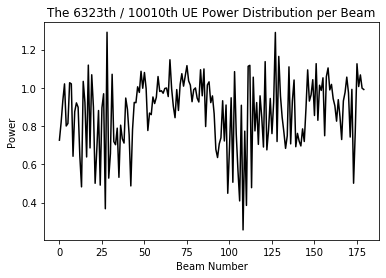

In [94]:
#plot randomly an user
def plotUser(mat):
    user_id = np.random.randint(0,mat.shape[1])
    plt.title('The '+str(user_id)+'th / '+str(mat.shape[1])+'th UE Power Distribution per Beam')
    plt.xlabel('Beam Number')
    plt.ylabel('Power')
    plt.plot(mat[:,user_id],linestyle='-',color='k')#print value distribution of a random UE
plotUser(mat)

In [95]:
#easy method: according to the best beam, roughly allocate all UEs beforehand into 8 groups, number of elements are not the same in each group.
#choose unified beam No in one group
def matIndex(mat):
    max_index = np.argmax(mat,axis=0).reshape(1,-1)
    max_value = np.amax(mat,axis=0).reshape(1,-1)
    org_index = np.arange(mat.shape[1]).reshape(1,-1)
    new_mat = np.vstack((max_index,org_index,max_value,mat))
    new_mat = new_mat.T[np.lexsort(new_mat[::-1,:])].T
    return max_index,org_index,max_value,new_mat
max_index,org_index,max_value,new_mat = matIndex(mat)
print(new_mat.shape)

(183, 10010)


In [96]:
#obtain an estimated group_size and remain
def estSize(max_index,num_group):
    return np.floor(max_index.shape[1]/num_group).astype(np.int64)
est_size = estSize(max_index,num_group)

In [97]:
def groupSize(max_index,est_size):
    px,py = np.unique(max_index,return_counts=True)
    d = dict(zip(px,py))
    count=1
    amount=0
    checkpoint=np.zeros((2,num_group+1),dtype=np.int64)
    checkpoint[0][0]=px[0]
    checkpoint[1][0]=amount
    for i in range(px.shape[0]):
        amount+=py[i]
        if (amount>=count*est_size)&(amount<(count+1)*est_size):
            checkpoint[0][count]=px[i]
            checkpoint[1][count]=amount
            count+=1
    return px,py,checkpoint
px,py,checkpoint=groupSize(max_index,est_size)
print(checkpoint)

[[    0    17    34    58    92   109   126   144   179]
 [    0  1318  2550  3763  5034  6269  7534  8816 10010]]


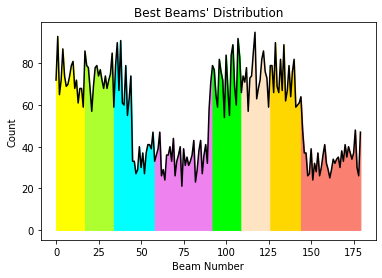

In [98]:
def plotBeam(px,py,checkpoint):
    plt.title('Best Beams\' Distribution')
    plt.xlabel('Beam Number')
    plt.ylabel('Count')
    plt.plot(px,py,linestyle='-',color='k')
    color=['yellow','greenyellow','aqua','violet','lime','bisque','gold','salmon','sandybrown']
    for i in range(0,num_group,1):
        plt.fill_between(px,py,where=((px>=checkpoint[0][i])&(px<=checkpoint[0][i+1])),color=color[i])
    #fig=plt.figure()
    #size=fig.get_size_inches()
    #print(size)
plotBeam(px,py,checkpoint)

In [99]:
def findValue(new_mat,checkpoint):
    #beam_wanted=np.empty(checkpoint.shape[1]-1,dtype=np.int64)
    result={}
    for i in range(checkpoint.shape[1]-1):
        div_mat=new_mat[3+checkpoint[0][i]:3+checkpoint[0][i+1],checkpoint[1][i]:checkpoint[1][i+1]]
        div_value=np.sum(div_mat,axis=1)
        beam_wanted=np.argmax(div_value,axis=0)+checkpoint[0][i]
        UE_corresponded=new_mat[1,checkpoint[1][i]:checkpoint[1][i+1]]
        result[beam_wanted]=UE_corresponded
    return result
result=findValue(new_mat,checkpoint)
pprint.pprint(result)

{4: array([  56.,   62.,  155., ..., 9918., 9986., 9993.]),
 20: array([  238.,   296.,   406., ...,  9653.,  9876., 10001.]),
 55: array([ 242.,  333.,  596., ..., 9864., 9889., 9998.]),
 61: array([ 712.,  808.,  953., ..., 9590., 9630., 9848.]),
 100: array([ 231.,  298.,  482., ..., 9852., 9900., 9984.]),
 116: array([5.000e+00, 5.260e+02, 6.410e+02, ..., 9.347e+03, 9.563e+03,
       9.718e+03]),
 140: array([3.000e+00, 4.500e+01, 6.000e+01, ..., 9.840e+03, 9.844e+03,
       9.968e+03]),
 145: array([  72.,  397.,  760., ..., 9215., 9434., 9519.])}


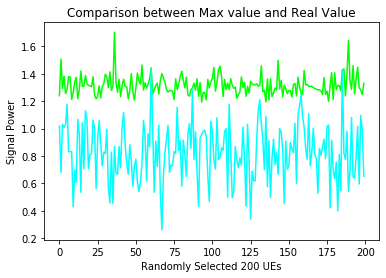

In [100]:
def plotValue(new_mat,result,checkpoint):
    
    max_value=new_mat[2,:].flatten()
    beam_wanted=[*result]
    real_value=np.empty(new_mat.shape[1])
    for i in range(len(beam_wanted)):
        real_value[checkpoint[1][i]:checkpoint[1][i+1]]=new_mat[3+i,checkpoint[1][i]:checkpoint[1][i+1]].flatten()
    color=['yellow','greenyellow','aqua','violet','lime','bisque','gold','salmon','sandybrown']
    plt.title('Comparison between Max value and Real Value')
    plt.xlabel('Randomly Selected 200 UEs')
    plt.ylabel('Signal Power')
    idx=np.random.randint(new_mat.shape[1],size=200)
    plt.plot(max_value[idx],linestyle='-',color='lime')
    plt.plot(real_value[idx],linestyle='-',color='aqua')
plotValue(new_mat,result,checkpoint)